In [1]:
suppressMessages(library("circular"))

# Functions from AS.circ

In [2]:
EM.vonmises <- function(x, k, max.runs = 1000, conv = 0.00001) {
    
    x <- circular(x)
    # provide starting values for mu, kappa, alpha
    mu <- circular(runif(k, 0, max(x)))
    kappa <- runif(k,0,1)
    alpha <- runif(k,0,1)
    alpha <- alpha/sum(alpha) # normalise to sum to 1
    
    # Support function - calculate log-likelihood
    
    log.likelihood <- function(x, mu, kappa, alpha, k) {
        l <- matrix(nrow = k, ncol = length(x))
        for (i in 1:k) {
            l[i,] <- alpha[i] * dvonmises(x, mu[i], kappa[i])
        }
        sum(log(colSums(l)))
    }
    
    log.lh <- log.likelihood(x, mu, kappa, alpha, k)
    new.log.lh <- abs(log.lh) + 100
    n = 0
    
    # create array to store initial values
    first.10 <- c(iter = n, mu = mu, kappa = kappa, alpha = alpha,
                  log.lh = log.lh)
    
    while ((abs(log.lh - new.log.lh) > conv) && (n < max.runs)) {
        
        # Estimation - calculate z_ij
        z <- matrix(0, ncol = length(x), nrow = k)
        for (i in 1:k){
            z[i,] <- alpha[i] * dvonmises(x, mu[i], kappa[i])
        }
        all.z <- colSums(z)
        for (i in 1:k){
            z[i,] <- z[i,] / all.z
        }
        
        # Maximisation - update parameters
        for (i in 1:k) {
            alpha[i] <- sum(z[i,]) / length (x)
            mu[i] <- atan2(sum(z[i,] * sin(x)), sum(z[i,] * cos(x)))
            kappa[i] <- A1inv(sum(z[i,] * (cos(x - mu[i]))) / sum(z[i,]))
            
            # correct for negative kappa if necessary
            if (kappa[i] < 0) {
                kappa[i] <- abs(kappa[i])
                mu[i] <- mu[i] + pi
            }
        }
        
        # calculate log-likelihoods for comparison
        log.lh <- new.log.lh
        new.log.lh <- log.likelihood(x, mu, kappa, alpha, k)
        n <- n + 1
        
        # save first 10 iterations
        if (n < 11) {
            next.iter <- c(iter = n, mu = mu, kappa = kappa, alpha = alpha,
                           log.lh = new.log.lh)
            first.10 <- rbind(first.10, next.iter)
        }
    }
    
    # Output: if model hasn't converged, show error message
    #         if it has, output the parameters & first 10 iterations
    if ((abs(log.lh - new.log.lh) > conv)) {
        cat ("Data hasn't converged after", n, "iterations; \n",
             "Difference in log-likelihoods is", 
             round(abs(log.lh - new.log.lh),6))
    } else {
        row.names(first.10) <- first.10[,1]
        list(k = k, mu = mu %% (2*pi), kappa = kappa, alpha = alpha,
             log.lh = new.log.lh)
    }
}

JP.mle <- function(data) {
    n <- length(data)
    s <- sum(sin(data))
    c <- sum(cos(data))
    
    # starting values: von Mises ML estimates
    muvM <- atan2(s,c) %% (2*pi)
    kapvM <- A1inv(sqrt(s*s+c*c)/n)
    
    # specify Jones-Pewsey log-likelihood function to optimize
    JPnll <- function(p){
        mu <- p[1] ; kappa <- p[2] ; psi <- p[3] ; parlim <- abs(kappa*psi)
        if (parlim > 10) {
            y <- 9999.0
            return(y)
        } else {
            ncon <- JP.NCon(kappa, psi)
            y <- -sum(log(JP.pdf(data, mu, kappa, psi, ncon)))
            return (y)
        }
    }
    
    # optimize the specified function - try-catch added to capture optimization errors
    out <- tryCatch({
        optim(par=c(muvM, kapvM, 0.001), fn=JPnll, gr = NULL, method = "L-BFGS-B",
              lower = c(muvM-pi, 0, -Inf), upper = c(muvM+pi, Inf, Inf), hessian = TRUE)
    }, 
    error=function(err) {list(value = NA, par = rep(NA, 3), HessMat = NA)} )
    
    list(maxll = -out$value,
         mu = out$par[1] %% (2*pi),
         kappa = out$par[2],
         psi = out$par[3],
         HessMat = out$hessian)
}


JP.NCon <- function(kappa, psi){
    if (kappa < 0.001) {ncon <- 1/(2*pi) ; return(ncon)} 
    else {
        eps <- 10*.Machine$double.eps
        if (abs(psi) <= eps) {ncon <- 1/(2*pi*I.0(kappa)) ; return(ncon)}
        
        
        else {
            intgrnd <- function(x){ (cosh(kappa*psi)+sinh(kappa*psi)*cos(x))**(1/psi) }
            
            ncon <- 1/integrate(intgrnd, lower=-pi, upper=pi)$value
            return(ncon) } }
}

JP.pdf <- function(theta, mu, kappa, psi, ncon){
    
    if (kappa < 0.001) {pdfval <- 1/(2*pi) ; return(pdfval)}
    else {
        eps <- 10*.Machine$double.eps
        if (abs(psi) <= eps) {
            pdfval <- ncon*exp(kappa*cos(theta-mu)) ; return(pdfval) }
        
        
        else { 
            pdfval <- (cosh(kappa*psi)+sinh(kappa*psi)*cos(theta-mu))**(1/psi)
            pdfval <- ncon*pdfval ; return(pdfval) } }
    
}

# Exploratory plots

In [3]:
# load hourly data (hourly mean & sd of wind speed & direction averaged over the Aegean region)
df <- read.csv("wind-hourly_ja_era5.csv")
df$year <- substr(df$time,1,4)
df$day <- substr(df$time,1,10)

In [4]:
tail(df)

,time,windfrom_mean,windfrom_sd,wspd_mean,wspd_sd,year,day
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
127404,2025-08-08 11:00:00,0.1114095,0.7244462,8.033035,3.153801,2025,2025-08-08
127405,2025-08-08 12:00:00,0.1081992,0.7197530,8.118076,3.051636,2025,2025-08-08
127406,2025-08-08 13:00:00,0.1021121,0.7078854,8.161781,3.058962,2025,2025-08-08
127407,2025-08-08 14:00:00,0.1034531,0.6978384,8.116501,3.111842,2025,2025-08-08
127408,2025-08-08 15:00:00,0.1081053,0.6800156,8.115824,3.210744,2025,2025-08-08
127409,2025-08-08 16:00:00,0.1464146,0.7004707,7.988416,3.279765,2025,2025-08-08


In [5]:
# create a circular object from the wind speeds
dir_2025 <- circular(df$windfrom_mean[df$year == 2025], template = "geographic")
mle_2025 <- mle.vonmises(dir_2025)

dir_clim <- circular(df$windfrom_mean[(df$year >= 1990) & (df$year <= 2020)], template = "geographic")
mle_clim <- mle.vonmises(dir_clim)

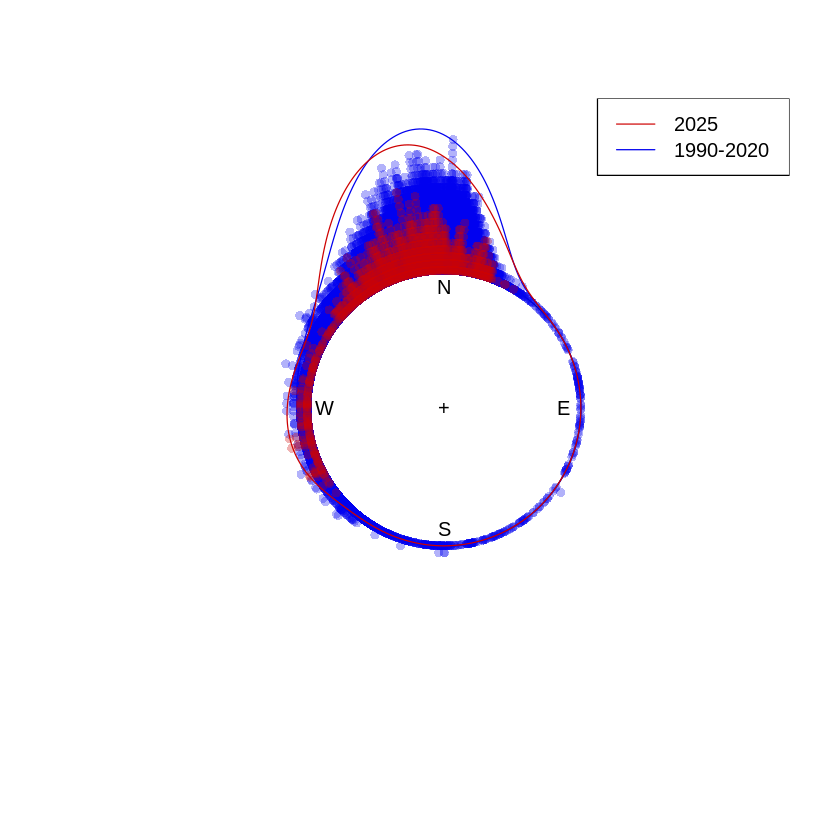

In [6]:
# KDE suggests 2025 is pretty similar to climatological distribution
plot(dir_clim, axes = T, shrink = 2, col = adjustcolor("blue2", 0.3), stack = T, sep = 0.05)
lines(density(dir_clim, bw = 25), col = "blue2")

points(dir_2025, shrink = 2, col = adjustcolor("red3", 0.3), stack = T, sep = 0.05)
lines(density(dir_2025, bw = 25), col = "red3")

legend("topright", c("2025", "1990-2020"), col = c("red3", "blue2"), lty = 1)

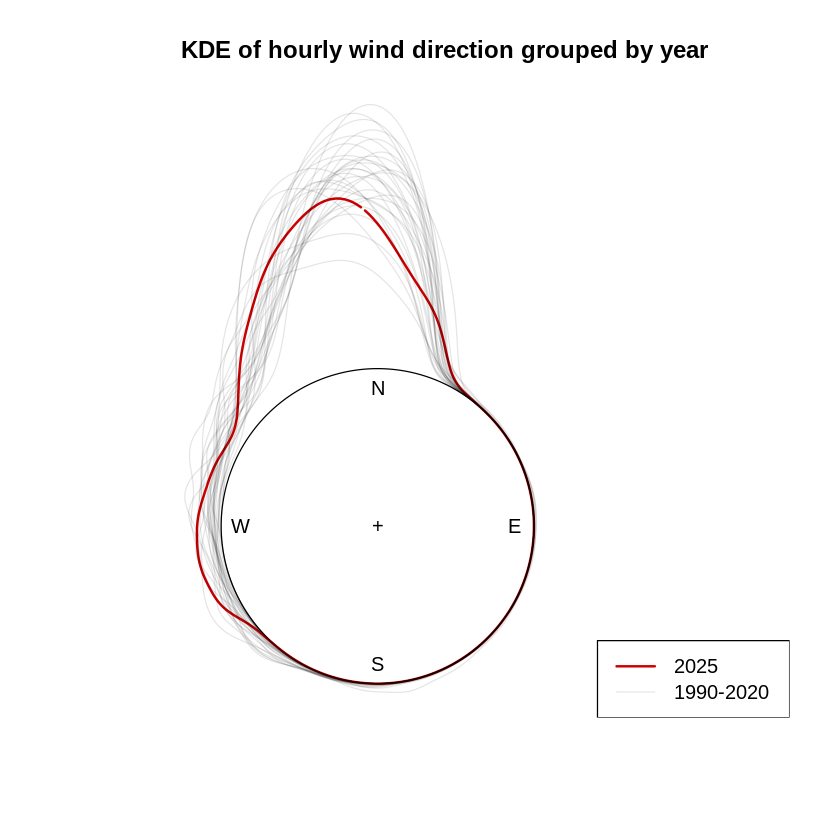

In [7]:
# what about indvidual years? How unusual is 2025?
plot(density(dir_2025, bw = 100), col = "red3", ylim = c(-1,2.5), xlim = c(0.3,0.55), lw = 2,
    main = "KDE of hourly wind direction grouped by year", xlab = "", ylab = "")

for (y in 1990:2020) {
    lines(density(circular(df$windfrom_mean[df$year == y], template = "geographic"), bw = 100), col = adjustcolor("black", 0.1))
}

legend("bottomright", c("2025", "1990-2020"), col = c("red3", adjustcolor("black", 0.1)), lty = 1, lwd = c(2,1))

## Get peak & central interval of density estimate

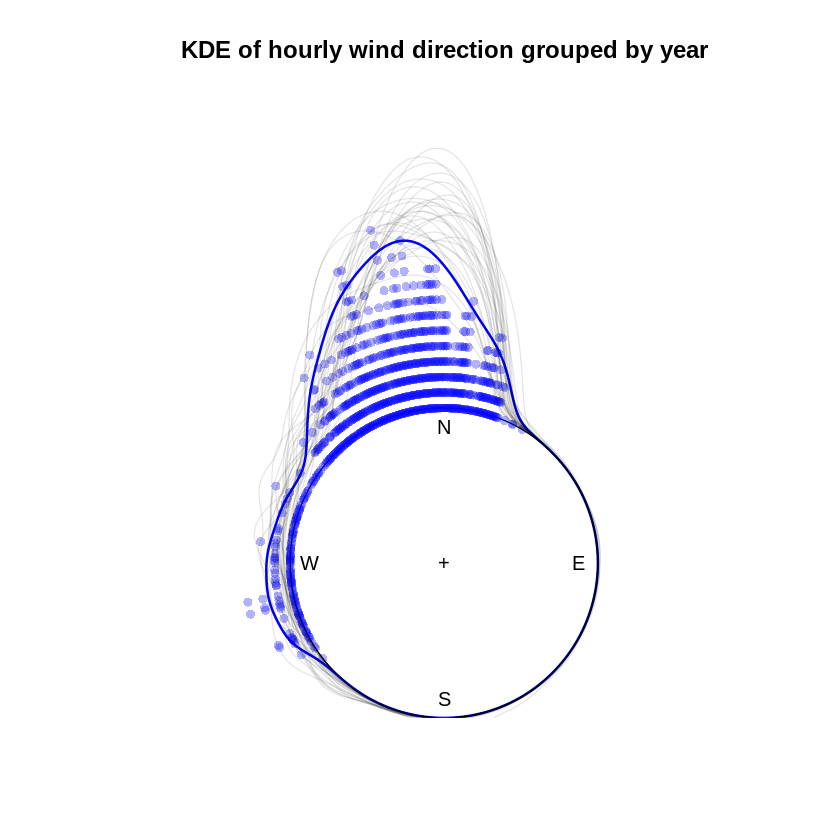

In [15]:
bw <- 100

plot(dir_2025, axes = T, shrink = 2, col = adjustcolor("blue", 0.3), stack = T, sep = 0.1,
    main = "KDE of hourly wind direction grouped by year", xlab = "", ylab = "", ylim = c(0,1))

lines(density(dir_2025, bw = bw), col = "blue", lw = 2)

for (y in 1990:2020) {
    lines(density(circular(df$windfrom_mean[df$year == y], template = "geographic"), bw = bw), col = adjustcolor("black", 0.1))
}

In [16]:
df$deg <- round(df$deg)

ERROR: Error in round(df$deg): non-numeric argument to mathematical function


In [ ]:
deg_2025 <- circular(df$deg[df$year == 2025], template = "geographic", units = "degrees")

plot(deg_2025, axes = T, shrink = 2, col = adjustcolor("red3", 0.3), stack = T, sep = 0.05,
    main = "KDE of hourly wind direction grouped by year", xlab = "", ylab = "", ylim = c(0,1))

lines(density(deg_2025, bw = bw), col = "red3", lw = 2)

for (y in 1990:2020) {
    lines(density(circular(df$deg[df$year == y], template = "geographic", units = "deg"), bw = bw), col = adjustcolor("blue2", 0.1))
}

# for (y in 1950:1980) {
#     lines(density(circular(df$deg[df$year == y], template = "geographic", units = "deg"), bw = bw), col = adjustcolor("black", 0.1))
# }

legend("topright", c("2025", "1990-2020"), col = c("red3", "blue2"), lty = 1)

## Width of central interval

In [ ]:
res <- data.frame(t(sapply(1940:2025, function(y) {
    dns <- density(circular(df$windfrom_mean[df$year == y], template = "geographic"), bw = bw)
    top52 <- circular(dns$x[order(dns$y, decreasing = T)][1:52], template = "geographic") # approx top 10% bounds
    setNames(c(top52[1], top52[order(top52 + pi)][c(1,52)]), c("mode", "lower", "upper"))
})))
rownames(res) <- 1940:2025

In [18]:
res_adj <- res + pi

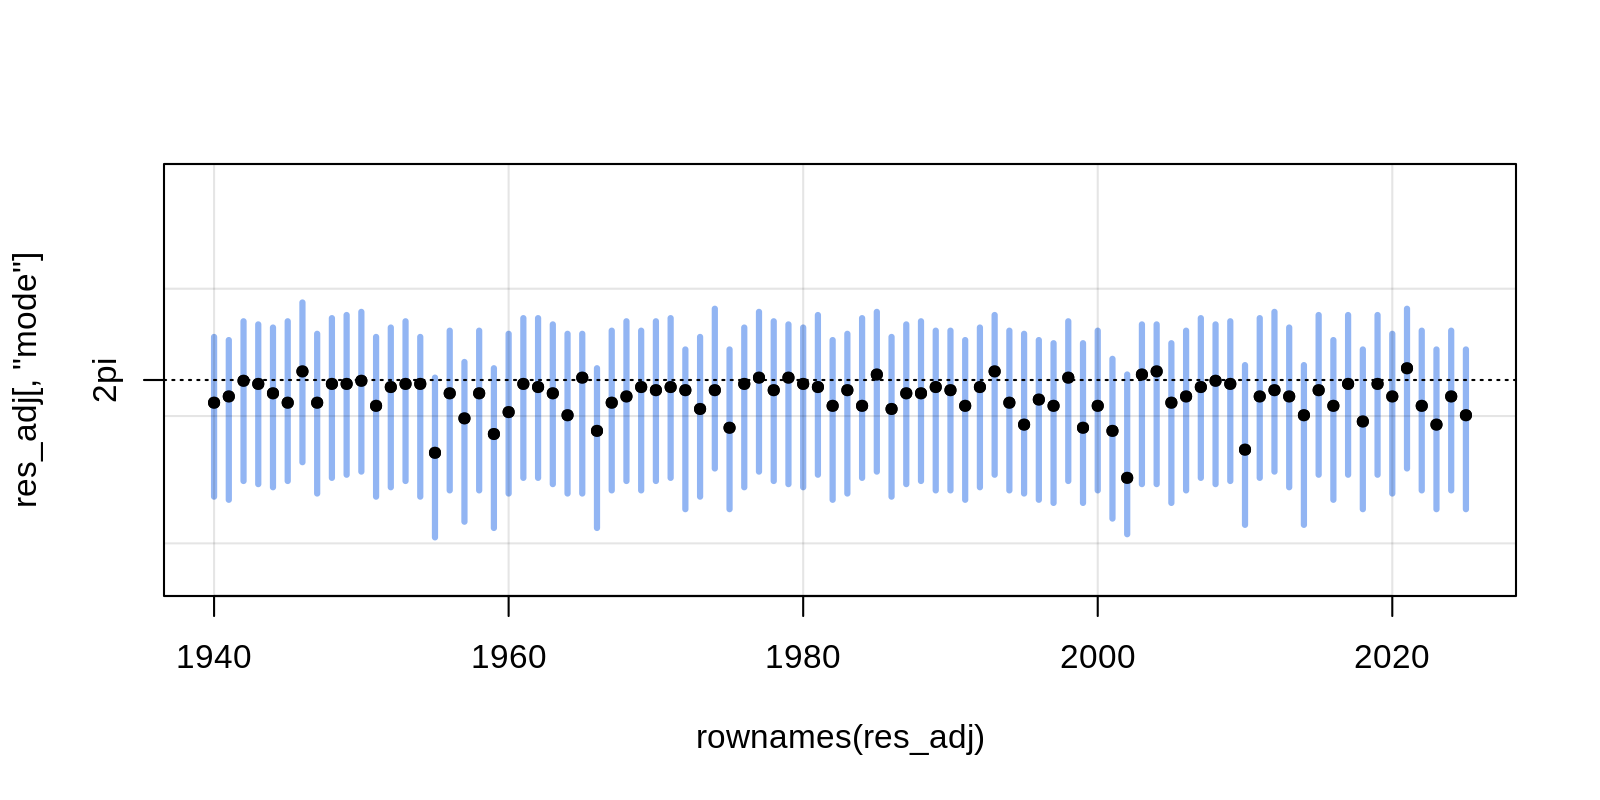

In [21]:
rwwa::prep_window(w = 8)

ylim <- c(3*pi/4,5*pi/4)
yticks <- data.frame(ticks = seq(0,2*pi, pi/4), labels = c("-pi","-3pi/4","-pi/2","-pi/4","2pi","pi/4","pi/2","3pi/4","pi"))
yticks <- yticks[(yticks$ticks > ylim[1]) & (yticks$ticks < ylim[2]),]

plot(rownames(res_adj), res_adj[,"mode"], pch = 20, ylim = ylim, yaxt = "n")
segments(x0 = as.integer(rownames(res_adj)), y0 = res_adj[,"lower"], y1 = res_adj[,"upper"], lwd = 3, col = adjustcolor("cornflowerblue", 0.7))
points(rownames(res_adj), res_adj[,"mode"], pch = 20)

grid(lty = 1, col = adjustcolor("black", 0.1))
axis(2, at = yticks$ticks, labels = yticks$labels)
abline(h = pi, lty = 3)

# Model fitting

## Von Mises

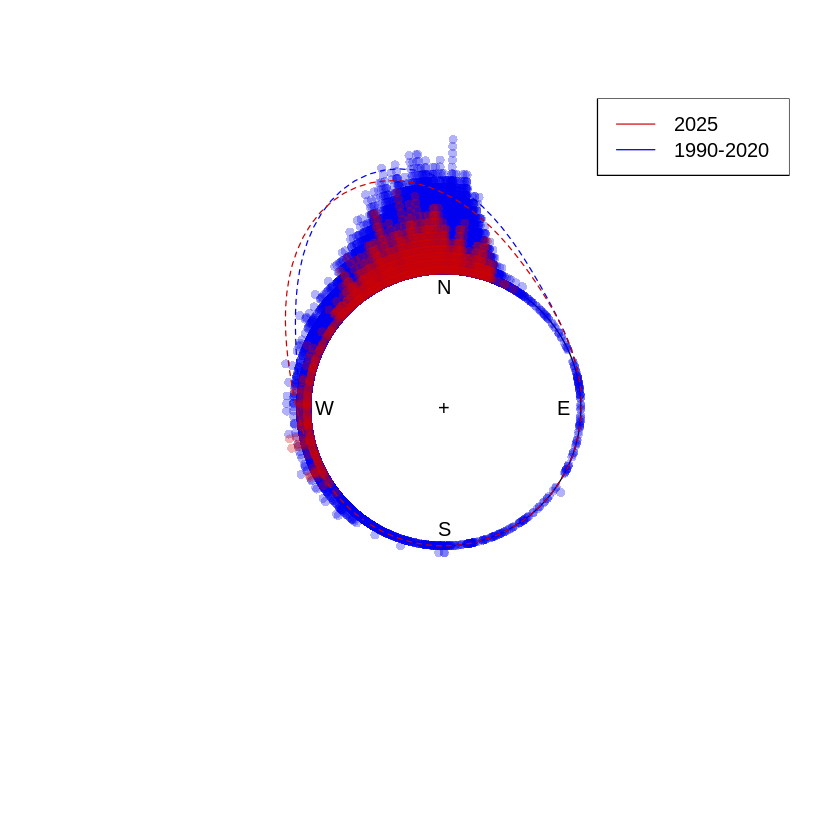

In [8]:
# single Von Mises doesn't capture shape well - needs a mixure really
plot(dir_clim, axes = T, shrink = 2, col = adjustcolor("blue2", 0.3), stack = T, sep = 0.05)
curve.circular(dvonmises(x, mu = mle_clim$mu, kappa = mle_clim$kappa), from = 0, to = 2*pi, add = T, col = "blue2", lty = 2)

points(dir_2025, shrink = 2, col = adjustcolor("red3", 0.3), stack = T, sep = 0.05)
curve.circular(dvonmises(x, mu = mle_2025$mu, kappa = mle_2025$kappa), from = 0, to = 2*pi, add = T, col = "red3", lty = 2)

legend("topright", c("2025", "1990-2020"), col = c("red3", "blue2"), lty = 1)

In [9]:
# unwrapping the data suggests two distinct clusters but third cluster gives better fit to peak
nclust = 3
set.seed(42)
mixt_2025 <- EM.vonmises(dir_2025, nclust)

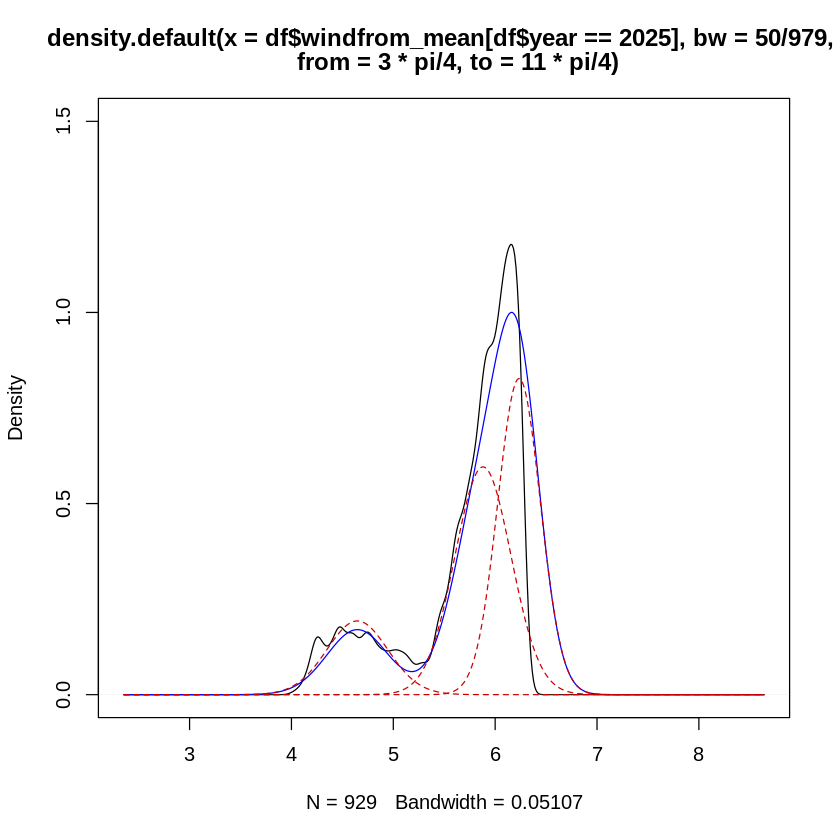

In [10]:
plot(density(df$windfrom_mean[df$year == 2025], from = 3*pi/4, to = 11*pi/4, bw = 50/979), ylim = c(0,1.5))
# lines(density(df$windfrom_mean[df$year == 2025], from = 3*pi/4, to = 11*pi/4))
# hist(((df$windfrom_mean[df$year == 2025] + 3*pi/2) %% 2*pi) + pi, breaks = "fd", add = T, prob = T, col = adjustcolor("lightblue", 0.5), border = NA)

x <- seq(3*pi/4, 11*pi/4, length.out = 512)

mixt_dns <- sapply(1:nclust, function(i) {
    suppressWarnings(dvonmises(x, mu = mixt_2025$mu[i], kappa = mixt_2025$kappa[i]) * mixt_2025$alpha[i])
})

lines(x, rowSums(mixt_dns) / max(rowSums(mixt_dns)), col = "blue")
matplot(x, mixt_dns, col = "red3", type = "l", add = T, lty = 2)

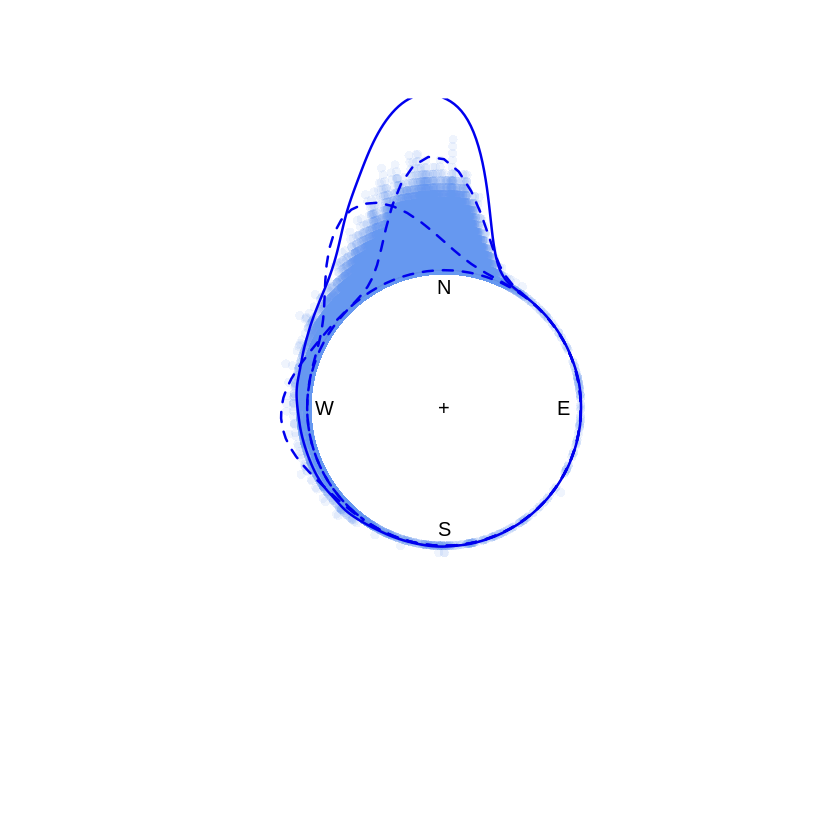

In [11]:
# single Von Mises doesn't capture shape well - needs a mixure really, and even then still not great
plot(dir_clim, axes = T, shrink = 2, col = adjustcolor("cornflowerblue", 0.1), stack = T, sep = 0.05)

for (i in 1:nclust) {
    curve.circular(dvonmises(x, mu = circular(mixt_2025$mu[i], template = "geographic"), kappa = mixt_2025$kappa[i])*mixt_2025$alpha[i],
               from = 0, to = 2*pi, add = T, col = "blue2", lty = 2, lwd = 2)
}

lines(density(dir_clim, bw = 240), col = "blue2", lwd = 2)

In [12]:
density(dir_clim, bw = 240)


Call:
	density.circular(x = dir_clim, bw = 240)

Data: dir_clim (46128 obs.);	Bandwidth 'bw' = 240

       x                    y            
 n      :512.000000   Min.   :0.0007537  
 Min.   :  4.706241   1st Qu.:0.0019274  
 1st Qu.:  3.135445   Median :0.0107193  
 Median :  1.570796   Mean   :0.1588467  
 Mean   :  1.570796   3rd Qu.:0.1039099  
 3rd Qu.:  0.006148   Max.   :1.2792708  
 Max.   : -1.564648                      
 Rho    :  0.001953                      

## Jones-Pewsey

In [13]:
# Jones-Pewsey? Still not skewed enough
jp_pars <- JP.mle(dir_2025)

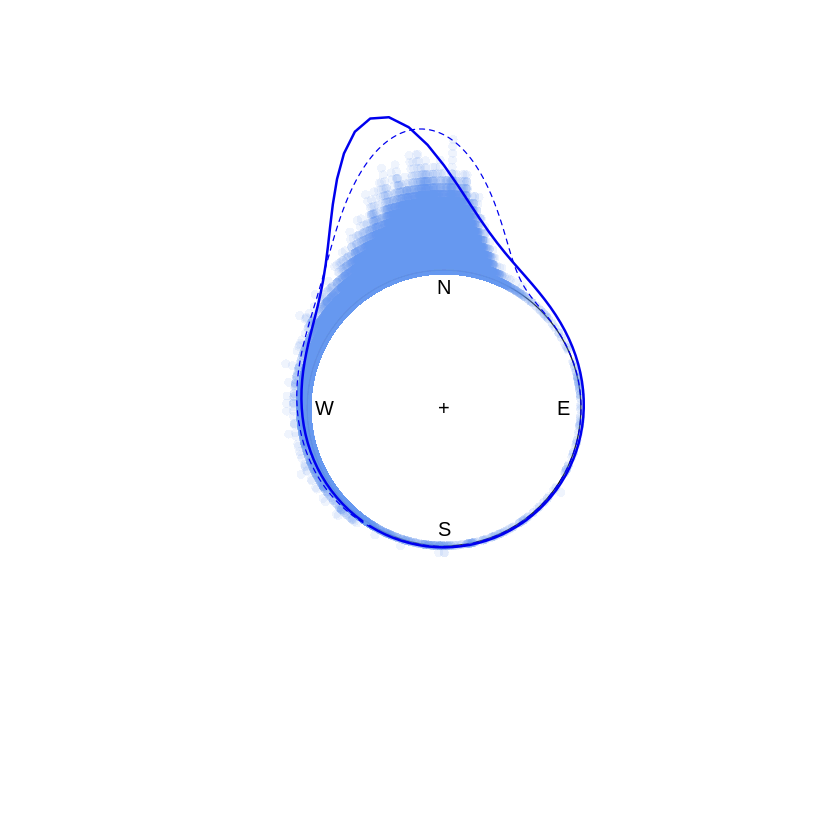

In [14]:
plot(dir_clim, axes = T, shrink = 2, col = adjustcolor("cornflowerblue", 0.1), stack = T, sep = 0.05)

curve.circular(djonespewsey(x, mu = circular(jp_pars$mu, template = "geographic"), kappa = jp_pars$kappa, psi = jp_pars$psi),
               from = 0, to = 2*pi, add = T, col = "blue2", lty = 1, lwd = 2)
lines(density(dir_clim, bw = 25), col = "blue2", lwd = 1, lty = 2)

# Is synoptic hour important?

In [15]:
prep_window(c(6,6), mar = c(0,0,0,0))

for (i in 0:23) {
    x_2025 <- circular(df[(df$year == 2025) & (df$hour == i), "windfrom_mean"], template = "geographic", units = "radian")
    x_2024 <- circular(df[(df$year == 2024) & (df$hour == i), "windfrom_mean"], template = "geographic", units = "radian")
    x_2023 <- circular(df[(df$year == 2023) & (df$hour == i), "windfrom_mean"], template = "geographic", units = "radian")
    plot(x_2025, axes = T, shrink = 1.75, col = "black", stack = T, sep = 0.05, main = "", xlab = "", ylab = "")
    points(x_2024, col = adjustcolor("red", 0.3), stack = T, sep = 0.05)
    points(x_2023, col = adjustcolor("blue", 0.3), stack = T, sep = 0.05)
    text(0,0.1,labels = i)
}

ERROR: Error in prep_window(c(6, 6), mar = c(0, 0, 0, 0)): could not find function "prep_window"
